### TASK: Create Encder-Decoder LSTM model to convert English sentences to Hindi sentences.  
We are going to use word level embedding

In [25]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

#Mount Drive

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preparing Data

### 1 .  Import Libraries

In [27]:

#%tensorflow_version 2.x

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers , activations , models , preprocessing , utils
import pandas as pd


### 2 . Read Data


In [28]:
!wget http://www.manythings.org/anki/hin-eng.zip -O hin-eng.zip

## IIT dataset : https://www.cfilt.iitb.ac.in/iitb_parallel/iitb_corpus_download/parallel.zip

!unzip hin-eng.zip


--2022-09-15 09:13:19--  http://www.manythings.org/anki/hin-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131711 (129K) [application/zip]
Saving to: ‘hin-eng.zip’

hin-eng.zip         100%[===================>] 128.62K   791KB/s    in 0.2s    

2022-09-15 09:13:20 (791 KB/s) - ‘hin-eng.zip’ saved [131711/131711]

Archive:  hin-eng.zip
  inflating: hin.txt                 
  inflating: _about.txt              


In [29]:
lines = pd.read_table( 'hin.txt' , names=[ 'eng' , 'hindi' ] )
lines.reset_index( level=0 , inplace=True )
lines.rename( columns={ 'index' : 'eng' , 'eng' : 'hindi' , 'hindi' : 'c' } , inplace=True )
lines = lines.drop( 'c' , 1 )

lines.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


,eng,hindi
0,Wow!,वाह!
1,Duck!,झुको!
2,Duck!,बतख़!
3,Help!,बचाओ!
4,Jump.,उछलो.


#Set Data Size

In [30]:
lines= lines[:1000]
lines.count()

eng      1000
hindi    1000
dtype: int64

### 3) Preparing input data for the Encoder ( `encoder_input_data` )
The Encoder model will be fed input data which are **preprocessed English sentences**. Following preprocessing is done:


1.   Tokenizing the Hindi sentences from `hindi_lines`.
2.   Determining the maximum length of the Hindi sentence that's `max_input_length`.
3.   Padding the `tokenized_hindi_lines` to the max_input_length.
4.   Determining the vocabulary size ( `num_hindi_tokens` ) for English words.





In [31]:
hindi_lines = list()
for line in lines.hindi:
    hindi_lines.append( line ) 

tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts( hindi_lines ) 
tokenized_hindi_lines = tokenizer.texts_to_sequences( hindi_lines ) 

length_list = list()
for token_seq in tokenized_hindi_lines:
    length_list.append( len( token_seq ))
max_input_length = np.array( length_list ).max()
print( 'Hindi max length is {}'.format( max_input_length ))

padded_hindi_lines = preprocessing.sequence.pad_sequences( tokenized_hindi_lines , maxlen=max_input_length , padding='post' )
encoder_input_data = np.array( padded_hindi_lines )
print( 'Encoder input data shape -> {}'.format( encoder_input_data.shape ))

hindi_word_dict = tokenizer.word_index
num_hindi_tokens = len( hindi_word_dict )+1
print( 'Number of Hindi tokens = {}'.format( num_hindi_tokens))

# print("Dictionary Eng word to tokens", eng_word_dict)














"""
Oov tokens are out of vocabulary tokens used to replace unknown words.
"""

Hindi max length is 12
Encoder input data shape -> (1000, 12)
Number of Hindi tokens = 1210


'\nOov tokens are out of vocabulary tokens used to replace unknown words.\n'

### 4) Preparing input data for the Decoder ( `decoder_input_data` )
The Decoder model will be fed the preprocessed Hindi lines. Preprocessing steps are similar to the ones which are above. This one step is carried out before the other steps.


*   Append `<START>` tag at the first position in  each Hindi sentence.
*   Append `<END>` tag at the last position in  each Hindi sentence.





In [32]:

eng_lines = list()
for line in lines.eng:
    eng_lines.append( '<START> ' + line + ' <END>' )  

tokenizer = preprocessing.text.Tokenizer(oov_token=1)
tokenizer.fit_on_texts( eng_lines ) 
tokenized_eng_lines = tokenizer.texts_to_sequences( eng_lines ) 

length_list = list()
for token_seq in tokenized_eng_lines:
    length_list.append( len( token_seq ))
max_output_length = np.array( length_list ).max()
print( 'English max length is {}'.format( max_output_length ))

padded_eng_lines = preprocessing.sequence.pad_sequences( tokenized_eng_lines , maxlen=max_output_length, padding='post' )
decoder_input_data = np.array( padded_eng_lines  )
print( 'Decoder input data shape -> {}'.format( decoder_input_data.shape ))

eng_word_dict = tokenizer.word_index
num_eng_tokens = len( eng_word_dict )+1
print( 'Number of English tokens = {}'.format( num_eng_tokens))

# print("Dictionary Hindi word to tokens", hindi_word_dict)


English max length is 9
Decoder input data shape -> (1000, 9)
Number of English tokens = 922


### 5) Preparing target data for the Decoder ( decoder_target_data ) 

We take a copy of `tokenized_hindi_lines` and modify it like this.



1.  Remove the `<start>` tag which we appended earlier. Hence, the word ( which is `<start>` in this case  ) will be removed.
2.   Convert the `padded_hindi_lines` ( ones which do not have `<start>` tag ) to one-hot vectors.

For example :

```
 [ '<start>' , 'hello' , 'world' , '<end>' ]

```

wil become 

```
 [ 'hello' , 'world' , '<end>' ]

```


In [33]:

decoder_target_data = list()
for token_seq in tokenized_eng_lines:
    decoder_target_data.append( token_seq[ 1 : ] ) 
    
padded_eng_lines = preprocessing.sequence.pad_sequences( decoder_target_data , maxlen=max_output_length, padding='post' )
onehot_eng_lines = utils.to_categorical( padded_eng_lines , num_eng_tokens )
decoder_target_data = np.array( onehot_eng_lines )
print( 'Decoder target data shape -> {}'.format( decoder_target_data.shape ))


Decoder target data shape -> (1000, 9, 922)


### 1) Defining the Encoder-Decoder model
The model will have Embedding, LSTM and Dense layers. The basic configuration is as follows.


*   2 Input Layers : One for `encoder_input_data` and another for `decoder_input_data`.
*   Embedding layer : For converting token vectors to fix sized dense vectors. **( Note :  Don't forget the `mask_zero=True` argument here )**
*   LSTM layer : Provide access to Long-Short Term cells.

Working : 

1.   The `encoder_input_data` comes in the Embedding layer (  `encoder_embedding` ). 
2.   The output of the Embedding layer goes to the LSTM cell which produces 2 state vectors ( `h` and `c` which are `encoder_states` )
3.   These states are set in the LSTM cell of the decoder.
4.   The decoder_input_data comes in through the Embedding layer.
5.   The Embeddings goes in LSTM cell ( which had the states ) to produce seqeunces.









In [34]:
from tensorflow.keras.layers import Input, Embedding,Dense,  LSTM

In [35]:
encoder_inputs = Input(shape=( max_input_length ,  ))
encoder_embedding = Embedding( num_hindi_tokens, 256 , mask_zero=True ) (encoder_inputs)
encoder_outputs , state_h , state_c = LSTM( 256 , return_state=True , recurrent_dropout=0.2 , dropout=0.2 )( encoder_embedding )
encoder_states = [ state_h , state_c ]

decoder_inputs = Input(shape=( max_output_length , ))
decoder_embedding = Embedding( num_eng_tokens, 256 , mask_zero=True) (decoder_inputs)
decoder_lstm = LSTM( 256 , return_state=True , return_sequences=True , recurrent_dropout=0.2 , dropout=0.2)
decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )
decoder_dense = Dense( num_eng_tokens , activation=tf.keras.activations.softmax ) 
output = decoder_dense ( decoder_outputs )

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy')

model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 12, 256)      309760      ['input_5[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 9, 256)       236032      ['input_6[0][0]']                
                                                                                            

### 2) Training the model
We train the model for a number of epochs with RMSprop optimizer and categorical crossentropy loss function.

In [36]:
mc = tf.keras.callbacks.ModelCheckpoint('my_nmt_model_min_loss.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')


In [37]:

history = model.fit([encoder_input_data , decoder_input_data], decoder_target_data, batch_size=250, epochs=100 ,
                     validation_split = 0.1,
                   callbacks=[mc], verbose=1    ) 
model.save( 'model.h5' ) 


Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 4.4800
Epoch 1: val_loss improved from inf to 5.48359, saving model to my_nmt_model_min_loss.h5
4/4 [==============================] - 10s 938ms/step - loss: 4.4800 - val_loss: 5.4836
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 4.4366
Epoch 2: val_loss improved from 5.48359 to 5.36378, saving model to my_nmt_model_min_loss.h5
4/4 [==============================] - 3s 723ms/step - loss: 4.4366 - val_loss: 5.3638
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 4.2508
Epoch 3: val_loss improved from 5.36378 to 4.68466, saving model to my_nmt_model_min_loss.h5
4/4 [==============================] - 3s 726ms/step - loss: 4.2508 - val_loss: 4.6847
Epoch 4/100
4/4 [==============================] - ETA: 0s - loss: 3.5705
Epoch 4: val_loss improved from 4.68466 to 4.09346, saving model to my_nmt_model_min_loss.h5
4/4 [==============================] - 3s 731ms/step - loss: 3.5705 - val_

In [38]:
from tensorflow import keras
saved_model = keras.models.load_model('model.h5')
saved_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 12, 256)      309760      ['input_5[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 9, 256)       236032      ['input_6[0][0]']                
                                                                                            

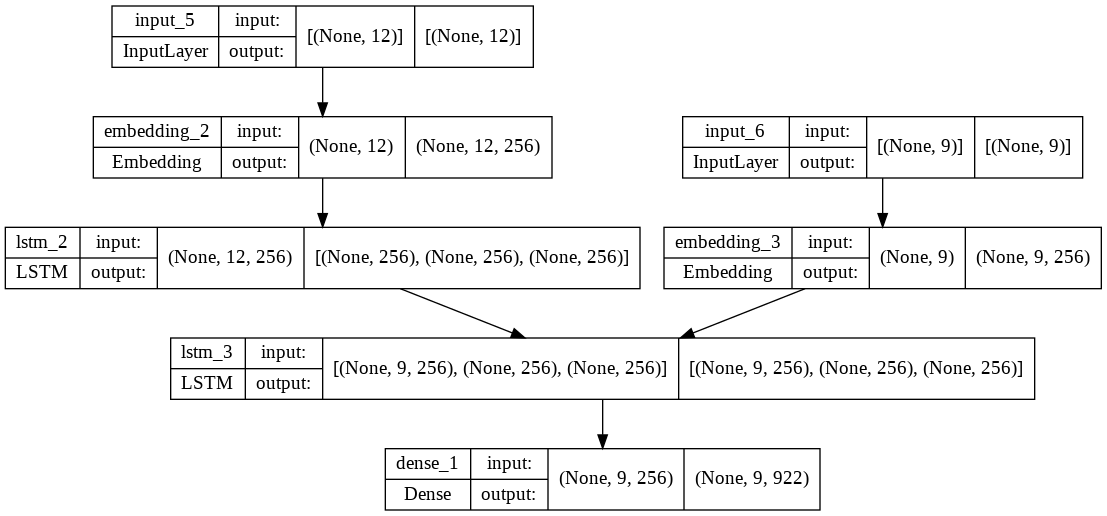

In [39]:
from keras.utils.vis_utils import plot_model
plot_model(saved_model, to_file='modelsummary.png', show_shapes=True, show_layer_names=True)

In [40]:
encoder_inputs = saved_model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = saved_model.layers[4].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)
latent_dim = 256  # Note: may be need to save in drive as well


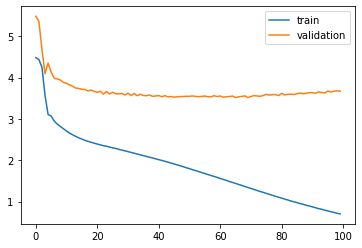

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])

## Inferencing on the models

### 1) Defining inference models
We create inference models which help in predicting translations.

**Encoder inference model** : Takes the English sentence as input and outputs LSTM states ( `h` and `c` ).

**Decoder inference model** : Takes in 2 inputs, one are the LSTM states ( Output of encoder model ), second are the French input seqeunces ( ones not having the `<start>` tag ). It will output the translations of the English sentence which we fed to the encoder model and its state values.





In [42]:

def make_inference_models():
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=( 256,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 256 ,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model


### 2) Making some translations


1.   First, we take a English sequence and predict the state values using `enc_model`.
2.   We set the state values in the decoder's LSTM.
3.   Then, we generate a sequence which contains the `<start>` element.
4.   We input this sequence in the `dec_model`.
5.   We replace the `<start>` element with the element which was predicted by the `dec_model` and update the state values.
6.   We carry out the above steps iteratively till we hit the `<end>` tag or the maximum sequence length.







In [43]:

def str_to_tokens( sentence : str ):
    words = sentence.lower().split()
    tokens_list = list()
    for word in words:
          print("word ", word,hindi_word_dict.get(word,1) )
          my_word=  hindi_word_dict.get(word,1)
          tokens_list.append(my_word) 
  
    return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=max_input_length , padding='post')


In [44]:

enc_model , dec_model = make_inference_models()

#encoder_input_data.shape[0] 
for epoch in range(1 ):
    states_values = enc_model.predict( str_to_tokens("मुझे खाने से प्यार है" ) )
    empty_target_seq = np.zeros( ( 1 , 1 ) )
    empty_target_seq[0, 0] = eng_word_dict['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
        sampled_word = None
        for word , index in eng_word_dict.items() :
            if sampled_word_index == index :
                decoded_translation += ' {}'.format( word )
                sampled_word = word
        
        if sampled_word == 'end' or len(decoded_translation.split()) > max_output_length:
            stop_condition = True
            
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        states_values = [ h , c ] 

    # print("Decoded Traslation ", decoded_translation )
    print(f"{bcolors.OKGREEN}Decoded Traslation: { decoded_translation}{bcolors.ENDC}")

    

word  मुझे 6
word  खाने 1
word  से 14
word  प्यार 82
word  है 4


Decoded Traslation:  i like to do it end


### Save Encoder and Decoder Parameters

In [45]:
%cd "drive/MyDrive/Machine Learning/GitHub Projects/machine-translation/models/"
model_name = str(lines.count().eng)
!mkdir $model_name
!ls
# save encoder model
enc_model.save( model_name+'/enc_model.h5' ) 
# save decoder model
dec_model.save( model_name+'/dec_model.h5' ) 
# save  model
saved_model.save( model_name+'/model.h5' ) 

[Errno 2] No such file or directory: 'drive/MyDrive/Machine Learning/GitHub Projects/machine-translation/models/'
/content/drive/MyDrive/Machine Learning/GitHub Projects/machine-translation/models
10    2909	  hin-eng.zip  model.h5		 my_nmt_model_min_loss.h5
1000  _about.txt  hin.txt      modelsummary.png


In [46]:
# encoder parameters
encoder_parameters={
    'max_encoder_seq_length': max_input_length,
    'num_encoder_tokens': num_eng_tokens,
   
}
encoder_dictionary= eng_word_dict

# decoder parameters
decoder_parameters={
    'max_decoder_seq_length':  max_output_length,
    'num_decoder_tokens': num_hindi_tokens,

}

decoder_dictionary=  hindi_word_dict



In [47]:
parameters=model_name+"/parameters/"
dictionaries=model_name+"/dictionaries/"
!mkdir $parameters
!mkdir $dictionaries


In [48]:
import pickle
paramters_path=parameters
dictionaries_path=dictionaries

# save encoder parameter
with open(paramters_path+'encoder_parameters.pickle', 'wb') as handle:
    pickle.dump(encoder_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)

# save encoder dictionary
with open(dictionaries_path+'encoder_dictionary.pickle', 'wb') as handle:
    pickle.dump(encoder_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

# save encoder parameter
with open(paramters_path+'decoder_parameters.pickle', 'wb') as handle:
    pickle.dump(decoder_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)

# save encoder parameter
with open(dictionaries_path+'decoder_dictionary.pickle', 'wb') as handle:
    pickle.dump(decoder_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)    

